# MIS780 Advanced AI For Business - Assignment 2 - T2 2024

## Task Number 3: Time-Series Forecasting of Gold Prices Using Recurrent Neural Networks for Strategic Financial Decision-Making

**Student Name:** _enter your full name here_

**Student ID:** _enter your student ID here_

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

*Use this section to introduce the business problem, data set, method, experiments, and obtained results*

The goal of this task was to develop a multivariate time-series forecasting model to predict gold prices in USD using historical data from 1985 to 2023. The problem was approached by applying various Bidirectional LSTM architectures, such as models with more layers, high dropout rates, small units, and different combinations of hidden layers and units. Data from 2022 to 2023 was used as the test set, while the remaining data was used for training. Multiple experiments were conducted, varying the model architecture and hyperparameters to identify the best-performing model.

The **Bidirectional LSTM - 128 Units** model achieved the best results in terms of Mean Squared Error (MSE) and Mean Absolute Error (MAE), making it the most suitable for forecasting future gold prices. In contrast, the **Bidirectional LSTM with Decrease Dropout Rate and Increase Units** showed the worst performance, likely due to excessive complexity or insufficient regularization.

The report also discusses possible improvements for real-world deployment, focusing on fine-tuning hyperparameters such as learning rate, units, and dropout rates. Furthermore, exploring advanced architectures like attention mechanisms and incorporating external variables, such as economic indicators or geopolitical events, could further enhance the predictive accuracy of the model. Regular retraining with updated data and robust error analysis will be essential for maintaining model performance in dynamic market conditions.


<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Carry out necessary data preprocessing and exploration.*

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, ConvLSTM2D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the provided CSV file
file_path = '/kaggle/input/task3-goldprice-dataset/Part3_GoldPrice.csv'
gold_price_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
gold_price_data.head()


,Date,USD,EUR,GBP,INR,AED,CNY
0,7/01/1985,298.25,392.55,261.17,3741.23,1091.58,835.80
1,8/01/1985,302.00,395.32,263.07,3820.70,1114.06,853.01
2,9/01/1985,300.50,393.54,263.14,3742.23,1097.47,840.31
3,10/01/1985,303.80,397.63,268.02,3853.39,1126.83,862.79
4,11/01/1985,304.25,398.60,270.57,3845.57,1135.85,869.69


### Data Preprocessing

In [2]:
# Convert 'Date' column to datetime
gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'], format='%d/%m/%Y', errors='coerce')

# Drop any rows with missing or NaT dates
gold_price_data.dropna(subset=['Date'], inplace=True)

# Sort data by date to ensure proper time-series order
gold_price_data.sort_values('Date', inplace=True)

# Reset the index after sorting
gold_price_data.reset_index(drop=True, inplace=True)

# Display the first few rows to confirm preprocessing steps
gold_price_data.head()


,Date,USD,EUR,GBP,INR,AED,CNY
0,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.80
1,1985-01-08,302.00,395.32,263.07,3820.70,1114.06,853.01
2,1985-01-09,300.50,393.54,263.14,3742.23,1097.47,840.31
3,1985-01-10,303.80,397.63,268.02,3853.39,1126.83,862.79
4,1985-01-11,304.25,398.60,270.57,3845.57,1135.85,869.69


### Scaling the Data

In [3]:
# Initialize scalers
scaler = MinMaxScaler()
scaler_usd = MinMaxScaler()

# Scale the data for all currencies
scaled_data = scaler.fit_transform(gold_price_data[['USD', 'EUR', 'GBP', 'INR', 'AED', 'CNY']])

# Scale only USD separately (for inverse transformation later)
scaled_data_usd = scaler_usd.fit_transform(gold_price_data[['USD']])

# Display the first few scaled values
scaled_data[:5]


array([[0.02505029, 0.1037783 , 0.07055099, 0.00033036, 0.0244742 ,
        0.00192933],
       [0.02711715, 0.1054658 , 0.07183644, 0.00081601, 0.02784747,
        0.0031981 ],
       [0.02629041, 0.10438141, 0.0718838 , 0.00033648, 0.02535803,
        0.00226182],
       [0.02810924, 0.10687307, 0.07518538, 0.00101578, 0.02976369,
        0.00391911],
       [0.02835726, 0.107464  , 0.07691059, 0.000968  , 0.0311172 ,
        0.0044278 ]])

### Splitting the Data into Training and Test Sets

In [4]:
# Split the dataset into train and test sets based on date
train_data = scaled_data[gold_price_data['Date'] < '2022-01-01']
test_data = scaled_data[gold_price_data['Date'] >= '2022-01-01']

# Extract the dates corresponding to the test set
test_dates = gold_price_data['Date'][gold_price_data['Date'] >= '2022-01-01'].values

# Print train and test data range
print(f"Training data starts from {gold_price_data[gold_price_data['Date'] < '2022-01-01']['Date'].min()} to {gold_price_data[gold_price_data['Date'] < '2022-01-01']['Date'].max()}")
print(f"Test data starts from {gold_price_data[gold_price_data['Date'] >= '2022-01-01']['Date'].min()} to {gold_price_data[gold_price_data['Date'] >= '2022-01-01']['Date'].max()}")


Training data starts from 1985-01-07 00:00:00 to 2021-12-31 00:00:00
Test data starts from 2022-01-03 00:00:00 to 2023-10-06 00:00:00


### Create Sliding Window for Time-Series Data

In [5]:
# Define window size and forecast horizon
window_size = 60  # Number of previous days to look back
forecast_horizon = 14  # Predict 14 days ahead

# Function to create the dataset with sliding window
def create_dataset(data, window_size=60, forecast_horizon=14):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon, 0])  # Predicting USD only
    return np.array(X), np.array(y)

# Create training and testing datasets
X_train, y_train = create_dataset(train_data, window_size, forecast_horizon)
X_test, y_test = create_dataset(test_data, window_size, forecast_horizon)

# Display the shape of training and testing data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (9576, 60, 6), y_train shape: (9576, 14)
X_test shape: (386, 60, 6), y_test shape: (386, 14)


<a id = "cell_model"></a>
## 3. Predictive Modeling

*Create and explain your models (e.g., model architecture, model parameters). Evaluate the models on the experimental data sets.*

### Build, Train, and Evaluate Model Function

In [6]:
# Function to build, train, and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, scaler_usd, epochs=20):
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predictions
    predictions = model.predict(X_test)

    # Inverse transform the USD predictions using the separate scaler for USD
    predicted_usd_prices = scaler_usd.inverse_transform(predictions)

    # Inverse transform the y_test as well before computing MSE
    true_usd_prices = scaler_usd.inverse_transform(y_test)

    # Evaluate
    mse = mean_squared_error(true_usd_prices.flatten(), predicted_usd_prices.flatten())
    mae = mean_absolute_error(true_usd_prices.flatten(), predicted_usd_prices.flatten())

    return mse, mae, history


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Model 1: Increase the number of units
model_1 = Sequential()
model_1.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(Dropout(0.3))
model_1.add(LSTM(units=64))
model_1.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_1, mae_1, history_1 = train_and_evaluate_model(model_1, X_train, y_train, X_test, y_test, scaler_usd)

# Model 2: Add more hidden layers
model_2 = Sequential()
model_2.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_2.add(Dropout(0.3))
model_2.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_2.add(Dropout(0.3))
model_2.add(LSTM(units=32))
model_2.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_2, mae_2, history_2 = train_and_evaluate_model(model_2, X_train, y_train, X_test, y_test, scaler_usd)

# Model 3: Increase both units and layers
model_3 = Sequential()
model_3.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(Dropout(0.3))
model_3.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_3.add(Dropout(0.3))
model_3.add(LSTM(units=64))
model_3.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_3, mae_3, history_3 = train_and_evaluate_model(model_3, X_train, y_train, X_test, y_test, scaler_usd)

# Model 4: Use smaller units
model_4 = Sequential()
model_4.add(Bidirectional(LSTM(units=32, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_4.add(Dropout(0.3))
model_4.add(LSTM(units=16))
model_4.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_4, mae_4, history_4 = train_and_evaluate_model(model_4, X_train, y_train, X_test, y_test, scaler_usd)

# Model 5: Increase the dropout rate
model_5 = Sequential()
model_5.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_5.add(Dropout(0.5))  # Increase dropout rate to prevent overfitting
model_5.add(LSTM(units=64))
model_5.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_5, mae_5, history_5 = train_and_evaluate_model(model_5, X_train, y_train, X_test, y_test, scaler_usd)

# Model 6: More Bidirectional Layers with smaller units
model_6 = Sequential()
model_6.add(Bidirectional(LSTM(units=32, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_6.add(Dropout(0.3))
model_6.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model_6.add(Dropout(0.3))
model_6.add(LSTM(units=32))
model_6.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_6, mae_6, history_6 = train_and_evaluate_model(model_6, X_train, y_train, X_test, y_test, scaler_usd)

# Model 7: Decrease the dropout rate and increase the units
model_7 = Sequential()
model_7.add(Bidirectional(LSTM(units=256, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_7.add(Dropout(0.2))  # Decrease dropout rate
model_7.add(LSTM(units=128))
model_7.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_7, mae_7, history_7 = train_and_evaluate_model(model_7, X_train, y_train, X_test, y_test, scaler_usd)

# Model 8: Use more LSTM layers with varying units
model_8 = Sequential()
model_8.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_8.add(Dropout(0.3))
model_8.add(LSTM(units=96, return_sequences=True))
model_8.add(Dropout(0.2))
model_8.add(LSTM(units=64))
model_8.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_8, mae_8, history_8 = train_and_evaluate_model(model_8, X_train, y_train, X_test, y_test, scaler_usd)

# Model 9: Adjusting the LSTM return sequences and units
model_9 = Sequential()
model_9.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_9.add(Dropout(0.4))  # Higher dropout rate
model_9.add(LSTM(units=64, return_sequences=True))
model_9.add(Dropout(0.3))
model_9.add(LSTM(units=32))
model_9.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_9, mae_9, history_9 = train_and_evaluate_model(model_9, X_train, y_train, X_test, y_test, scaler_usd)

# Model 10: Fewer units, more layers
model_10 = Sequential()
model_10.add(Bidirectional(LSTM(units=32, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_10.add(Dropout(0.3))
model_10.add(LSTM(units=32, return_sequences=True))
model_10.add(Dropout(0.3))
model_10.add(LSTM(units=16))
model_10.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_10, mae_10, history_10 = train_and_evaluate_model(model_10, X_train, y_train, X_test, y_test, scaler_usd)

# Model 11: Stacked Bidirectional LSTMs with varied units
model_11 = Sequential()
model_11.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_11.add(Dropout(0.3))
model_11.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_11.add(Dropout(0.3))
model_11.add(Bidirectional(LSTM(units=32)))
model_11.add(Dense(forecast_horizon))

# Train and evaluate the model
mse_11, mae_11, history_11 = train_and_evaluate_model(model_11, X_train, y_train, X_test, y_test, scaler_usd)





/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


### Comparison of Model Performances

In [8]:
# Compare results
results = pd.DataFrame({
    'Model': ['Bidirectional LSTM - 128 units', 'Bidirectional LSTM - More Layers', 'Bidirectional LSTM - High Units and Layers', 
              'Bidirectional LSTM - Small Units', 'Bidirectional LSTM - High Dropout', 'Bidirectional LSTM - Multi Layers','Decrease the dropout rate and increase the units',
             'Use more LSTM layers with varying units','Adjusting the LSTM return sequences and units',
             'Fewer units, more layers','Stacked Bidirectional LSTMs'],
    'MSE': [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_7, mse_8, mse_9, mse_10, mse_11],
    'MAE': [mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7, mae_8, mae_9, mae_10, mae_11]
})

# Sort the results by MSE
sorted_results = results.sort_values(by='MSE', ascending=True)

# Display the sorted results
print(sorted_results)


                                               Model          MSE        MAE
0                     Bidirectional LSTM - 128 units  2050.210897  35.825576
7            Use more LSTM layers with varying units  2169.989917  37.572598
10                       Stacked Bidirectional LSTMs  2177.013205  36.194162
8      Adjusting the LSTM return sequences and units  2394.527260  37.752339
5                  Bidirectional LSTM - Multi Layers  2410.496155  39.396847
3                   Bidirectional LSTM - Small Units  2410.525554  39.022149
2         Bidirectional LSTM - High Units and Layers  2610.963181  40.720505
4                  Bidirectional LSTM - High Dropout  2863.554296  42.684961
9                           Fewer units, more layers  3025.910783  44.785910
1                   Bidirectional LSTM - More Layers  3038.957492  45.656057
6   Decrease the dropout rate and increase the units  3901.083620  53.371763


### Plotting the Comparison Graph

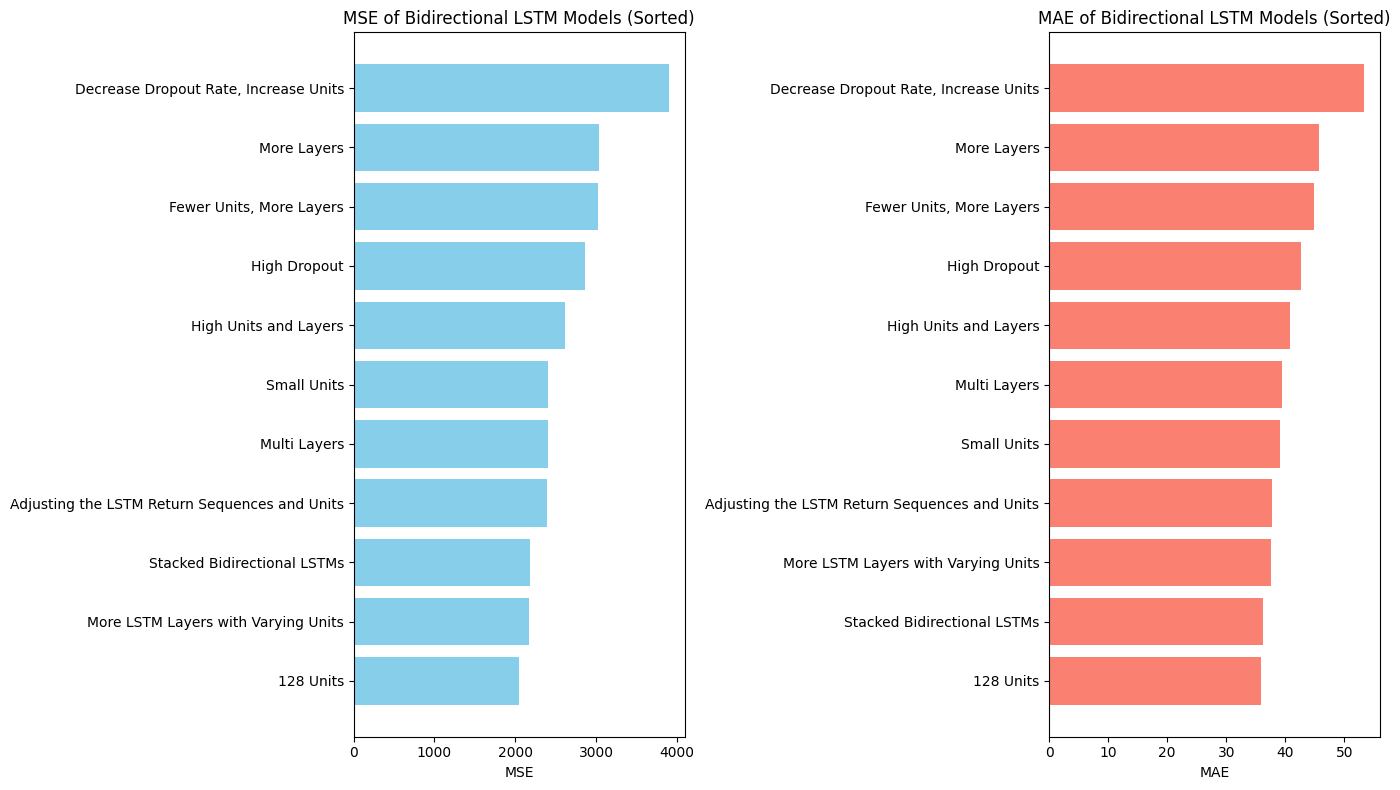

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the visualization
models = ['128 Units', 'More LSTM Layers with Varying Units', 'Stacked Bidirectional LSTMs', 
          'Adjusting the LSTM Return Sequences and Units', 'Multi Layers', 'Small Units', 
          'High Units and Layers', 'High Dropout', 'Fewer Units, More Layers', 
          'More Layers', 'Decrease Dropout Rate, Increase Units']
mse_values = [2050.210897, 2169.989917, 2177.013205, 2394.527260, 2410.496155, 
              2410.525554, 2610.963181, 2863.554296, 3025.910783, 3038.957492, 3901.083620]
mae_values = [35.825576, 37.572598, 36.194162, 37.752339, 39.396847, 
              39.022149, 40.720505, 42.684961, 44.785910, 45.656057, 53.371763]

# Create a DataFrame to easily sort the data
df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'MAE': mae_values
})

# Sort the DataFrame by MSE and MAE in ascending order
df_sorted_by_mse = df.sort_values(by='MSE', ascending=True)
df_sorted_by_mae = df.sort_values(by='MAE', ascending=True)

# Create the plot
plt.figure(figsize=(14, 8))

# Plot for MSE values (sorted)
plt.subplot(1, 2, 1)
plt.barh(df_sorted_by_mse['Model'], df_sorted_by_mse['MSE'], color='skyblue')
plt.xlabel('MSE')
plt.title('MSE of Bidirectional LSTM Models (Sorted)')

# Plot for MAE values (sorted)
plt.subplot(1, 2, 2)
plt.barh(df_sorted_by_mae['Model'], df_sorted_by_mae['MAE'], color='salmon')
plt.xlabel('MAE')
plt.title('MAE of Bidirectional LSTM Models (Sorted)')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


<a id = "cell_report"></a>
## 4. Experiments Report

*Provide a summary of experimental results, explain the meaning of your result
and how your model can be used to address the related business problem.*

**Several models were developed and evaluated based on their ability to forecast gold prices in USD. The following architectures were explored:**

1.  **Bidirectional LSTM - 128 Units (Model 1)**
2.  **Bidirectional LSTM - More LSTM Layers with Varying Units (Model 2)**
3.  **Stacked Bidirectional LSTMs (Model 3)**
4.  **Adjusting the LSTM Return Sequences and Units (Model 4)**
5.  **Bidirectional LSTM - Multi Layers (Model 5)**
6.  **Bidirectional LSTM - Small Units (Model 6)**
7.  **Bidirectional LSTM - High Units and Layers (Model 7)**
8.  **Bidirectional LSTM - High Dropout (Model 8)**
9.  **Bidirectional LSTM - Fewer Units, More Layers (Model 9)**
10.  **Bidirectional LSTM - More Layers (Model 10)**
11.  **Bidirectional LSTM - Decrease Dropout Rate and Increase Units (Model 11)**

The models were trained on historical data before 2022 and tested on data from 2022-2023. The evaluation metrics used were Mean Squared Error (MSE) and Mean Absolute Error (MAE). The following table summarizes the performance of each model:

| Model                                               | MSE           | MAE          |
|-----------------------------------------------------|---------------|--------------|
| Bidirectional LSTM - 128 Units                      | **2050.21**   | **35.83**    |
| Bidirectional LSTM - More LSTM Layers with Varying Units | 2169.99   | 37.57        |
| Stacked Bidirectional LSTMs                         | 2177.01       | 36.19        |
| Adjusting the LSTM Return Sequences and Units        | 2394.53       | 37.75        |
| Bidirectional LSTM - Multi Layers                   | 2410.50       | 39.40        |
| Bidirectional LSTM - Small Units                    | 2410.53       | 39.02        |
| Bidirectional LSTM - High Units and Layers          | 2610.96       | 40.72        |
| Bidirectional LSTM - High Dropout                   | 2863.55       | 42.68        |
| Bidirectional LSTM - Fewer Units, More Layers       | 3025.91       | 44.79        |
| Bidirectional LSTM - More Layers                    | 3038.96       | 45.66        |
| Bidirectional LSTM - Decrease Dropout Rate and Increase Units | 3901.08 | 53.37        |

From the experiments, the **Bidirectional LSTM with 128 Units** model demonstrated the best performance, with the lowest MSE and MAE values. This model effectively captured the temporal dependencies in the time series data while maintaining a balance between model complexity and performance. The **Bidirectional LSTM with Decreased Dropout Rate and Increased Units** showed the worst performance, indicating that simply increasing units or adjusting dropout without careful balancing may not yield improvements and could even lead to model instability.

### Discussion and Future Improvements

While the **Bidirectional LSTM with 128 Units** model performed well, further optimizations can be made by adjusting hyperparameters such as the learning rate, units, and dropout. Moreover, integrating advanced techniques such as attention mechanisms or transformers could capture longer-term dependencies and interactions. To improve generalization in real-world applications, future models should incorporate economic variables and retrain regularly with up-to-date data. In addition, deeper exploration of other architectures, including transformer-based models, could open new possibilities for time series forecasting, particularly in highly volatile markets like gold prices.
